In [1]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from datetime import datetime



import IPython
from IPython.display import display, Image
import ipywidgets as widgets
from tqdm import tqdm
import pytz # Python Timezone


In [49]:
def create_dataset():
    # Reading CSV
    train = pd.read_csv("chexpert/train.csv") # dataframe
    valid = pd.read_csv("chexpert/valid.csv") # dataframe
    train["Path"] = train["Path"].apply(lambda x: x.replace("CheXpert-v1.0-small", "chexpert"))
    valid["Path"] = valid["Path"].apply(lambda x: x.replace("CheXpert-v1.0-small", "chexpert"))
    
    train_labels = []
    for path in tqdm(train["Path"]):
        if "frontal" in path:
            train_labels.append(1)
        elif "lateral" in path:
            train_labels.append(0)
        else:
            print(path)  

    train_labels = np.array(train_labels)
    count_lateral = (train_labels == 0).sum()
    count_frontal = (train_labels == 1).sum()
    print("Lateral: ", count_lateral , "Frontal: ", count_frontal, "Total: ", count_frontal + count_lateral)
    
    train_img = []
    train_labels = []
    test_img = []
    test_label = []
    new_count_frontal = 0
    
    for path in tqdm(train["Path"]):
        if "frontal" in path:
            if new_count_frontal < count_lateral:
                train_labels.append(1)
                new_count_frontal += 1
            else:
                test_label.append(0)
                image = PIL.Image.open(path)
                image = image.resize((128, 128))
                test_img.append(np.asarray(image))
                continue 
        elif "lateral" in path:
            train_labels.append(0)

        else: 
            print("Should not be getting here")
            continue

        image = PIL.Image.open(path)
        image = image.resize((128, 128))
        train_img.append(np.asarray(image))
    
    train_img = np.array(train_img)
    train_labels = np.array(train_labels)
    test_img = np.array(test_img)
    test_label = np.array(test_label)
    
    valid_img = []
    valid_labels = []
    
    for path in tqdm(valid["Path"]):
        if "frontal" in path:
            valid_labels.append(1)
        elif "lateral" in path:
            valid_labels.append(0)

        else: 
            continue

        image = PIL.Image.open(path)
        image = image.resize((128, 128))
        valid_img.append(np.asarray(image))
    
    valid_img = np.array(valid_img)
    valid_labels = np.array(valid_labels)

    np.save('train_img.npy', train_img)
    np.save('train_labels.npy', train_labels)
    np.save('valid_img.npy', valid_img)
    np.save('valid_labels.npy', valid_labels)
    np.save('test_img.npy', test_img)
    np.save('test_labels.npy', test_label)
    
#create_dataset()

In [50]:
def load_dataset():
    def preprocess(x):
        x = x.astype(np.float32) / 255 # gray scale to floating point
        x = np.expand_dims(x, axis=3)
        return x
    x_train = np.load('train_img.npy')
    x_train = preprocess(x_train)
    y_train = np.load('train_labels.npy')
    
    x_val = np.load('valid_img.npy')
    x_val= preprocess(x_val)
    
    y_val = np.load('valid_labels.npy')
    
    x_test = np.load('test_img.npy')
    x_test = preprocess(x_test)
    
    y_test = np.load('test_labels.npy')
    return x_train, y_train, x_val, y_val, x_test, y_test
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset()


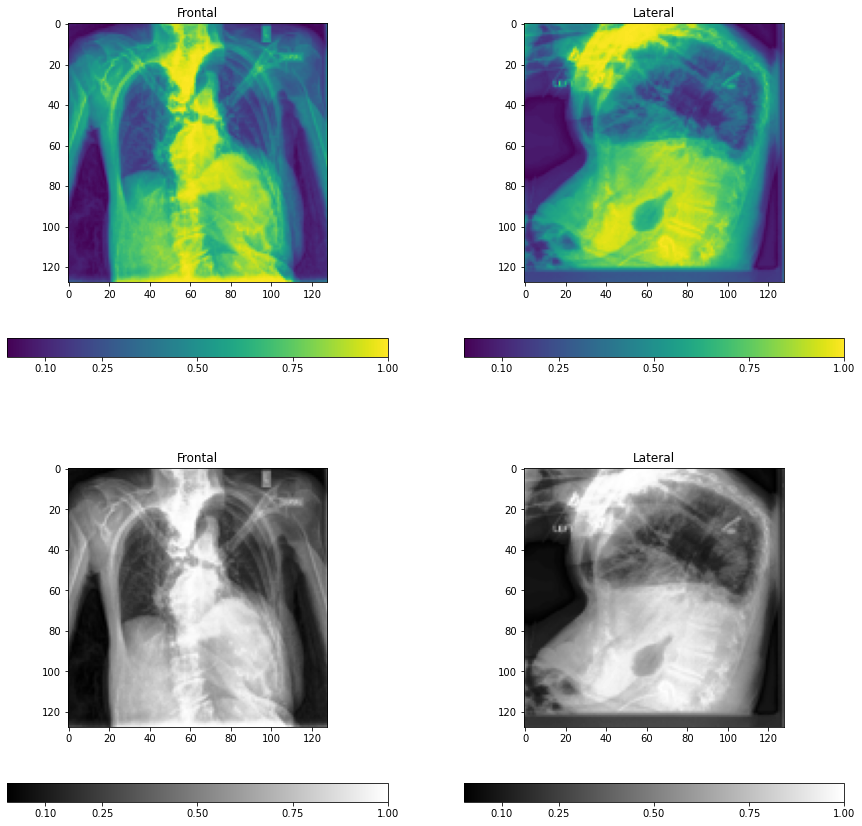

In [51]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(x_train[1])
ax.set_title('Frontal')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(x_train[3])
ax.set_title('Lateral')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(x_train[1], cmap='gray')
ax.set_title('Frontal')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(x_train[3], cmap='gray')
ax.set_title('Lateral')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')

In [23]:
y_train[2]

1

In [46]:
def compile_train_save(epochs = 10, batch_size = 64):
    def decorator(func):
        def wrapper():
            model = func()
            model.summary()
            def loss(labels, logits):
                return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)

            optimizer = SGD(learning_rate=0.008, momentum=0.9)
            model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
            hist = model.fit(x_train, y_train, 
                  epochs=epochs, batch_size=batch_size, 
                  validation_data=(x_val, y_val), 
                  verbose=1)
            model.save("model/%s[%f][%f]-" % (func.__name__, hist.history['accuracy'][-1],hist.history['val_accuracy'][-1]) + datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%c") + ".h5")
            return model

        return wrapper
    return decorator

In [13]:
@compile_train_save(epochs = 20)
def Logistic_Regression():
    # 2. Model Construction
    model = Sequential()
    model.add(Flatten(input_shape=(128,128,1)))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = Logistic_Regression()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 16385     
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1013/1013 [==============================] - 2s 2ms/step - loss: 0.5149 - accuracy: 0.9764 - val_loss: 0.3702 - val_accuracy: 0.9872
Epoch 2/20
1013/1013 [==============================] - 2s 2ms/step - loss: 0.5101 - accuracy: 0.9868 - val_loss: 0.3714 - val_accuracy: 0.9872
Epoch 3/20
1013/1013 [==============================] - 2s 2ms/step - loss: 0.5097 - accuracy: 0.9877 - val_loss: 0.3702 - val_accuracy: 0.9872
Epoch 4/20
1013/1013 [==============================] - 2s 2ms/step - loss: 0.50

In [6]:
@compile_train_save
def Dense_Model():
    # 2. Model Construction
    model = Sequential()
    model.add(Flatten(input_shape=(128,128,1)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.build((128,128,1))
    return model

model = Dense_Model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,105,601
Trainable params: 2,105,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1013/1013 [==============================] - 4s 4ms/step - loss: 0.5121 - accuracy: 0.9830 - val_loss: 0.3698 - val_accuracy: 0.9872
Epoch 2/10
1013/1013 [==============================] - 4s 4ms/step - loss: 0.5078 - accuracy: 0.9

In [15]:
@compile_train_save()
def Convolutional_Model():
    # 2. Model Construction
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(128,128,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = Convolutional_Model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12300900  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 12,301,833
Trainable params: 12,301,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1013/1013 [==============================] - 136s 134ms/step - loss: 0.5133 - accuracy: 0.9796 - 

In [16]:
@compile_train_save()
def Bigger_Convolutional_Model():
    # 2. Model Construction
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(128,128,1)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = Bigger_Convolutional_Model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               3075300   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 3,076,233
Trainable params: 3,076,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1013/1013 [==============================] - 98s 97ms/step - loss: 0.5161 - accuracy: 0.9759 - val_

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)

optimizer = SGD(learning_rate=0.008, momentum=0.9)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
hist = model.fit(x_train, y_train, 
          epochs=10, batch_size=64, 
          validation_data=(x_test, y_test), 
          verbose=1)
model.save("model/Model[%f][%f]-" % (hist.history['accuracy'][-1],hist.history['val_accuracy'][-1])  + datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%c") + ".h5")

In [ ]:
def test_models():
    get_custom_objects().update({"loss": loss})
    for path in glob.glob("model/*.h5"):
        new_model = tf.keras.models.load_model(path)
        print(path)
        new_model.evaluate(x_train, y_train)
        new_model.evaluate(x_test, y_test)
test_models()